In [1]:
!pip install shap


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Dataset Path
dataset_path = "train"

In [ ]:
# Image Preprocessing Function (For Oranges Only)
def load_orange_images(dataset_path, image_size=(224, 224)):
    images, labels = [], []

    orange_path = os.path.join(dataset_path)  
    if not os.path.isdir(orange_path):
        raise FileNotFoundError("Orange folder not found in dataset!")

    for class_folder in os.listdir(orange_path):  
        class_path = os.path.join(orange_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Skipping invalid image: {image_path}")
                continue

            image = cv2.resize(image, image_size)
            images.append(image)
            labels.append(class_folder)  

    return np.array(images), np.array(labels)


In [6]:

X, y = load_orange_images(dataset_path)

In [9]:
# Normalize Images
X = X / 255.0

In [10]:
# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [ ]:
import h5py
import numpy as np

with h5py.File("orange_dataset.h5", "w") as f:
    f.create_dataset("X", data=X, compression="gzip")
    f.create_dataset("y_encoded", data=y_encoded, compression="gzip")
    f.create_dataset("labels", data=np.array(label_encoder.classes_, dtype="S"))  


In [ ]:
import h5py
with h5py.File("orange_dataset.h5", "r") as f:
    print("Available datasets in file:", list(f.keys())) 

Available datasets in file: ['X', 'labels', 'y_encoded']


In [ ]:

import h5py
import numpy as np

with h5py.File("orange_dataset.h5", "r") as f:
    X = f["X"][:]  
    y_encoded = f["y_encoded"][:] 
    class_labels = np.array(f["labels"]).astype(str)  

print("Dataset loaded successfully!")
print(f"Shape of X: {X.shape}")
print(f"Shape of y_encoded: {y_encoded.shape}")
print(f"Class labels: {class_labels}")



Dataset loaded successfully!
Shape of X: (8299, 224, 224, 3)
Shape of y_encoded: (8299,)
Class labels: ['citrus canker' 'healthy' 'melanose']


Text(0, 0.5, 'Count')

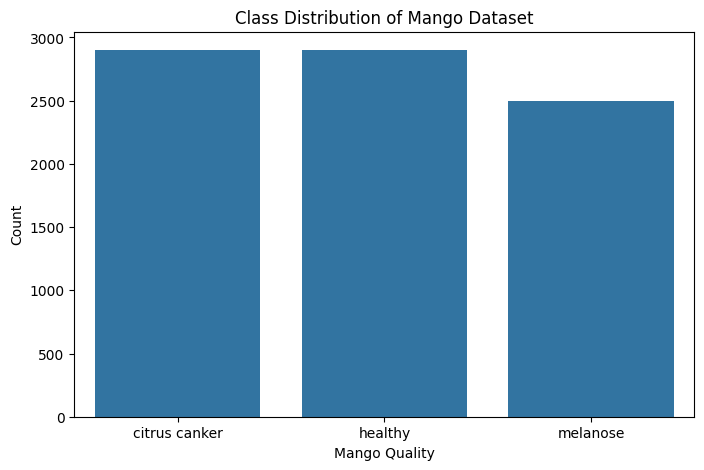

In [ ]:
# Visualizing Class Distribution
plt.figure(figsize=(8,5))
sns.countplot(x=y, order=np.unique(y))
plt.title("Class Distribution of Orange Dataset")
plt.xlabel("Orange Quality")
plt.ylabel("Count")

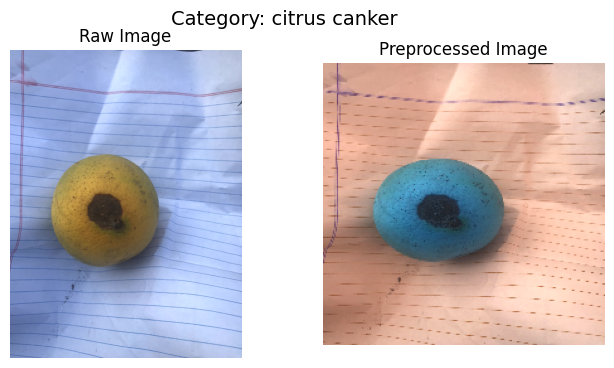

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_visualize_orange_images(dataset_path, image_size=(224, 224)):
    orange_path = os.path.join(dataset_path) 
    if not os.path.isdir(orange_path):
        raise FileNotFoundError("Mango folder not found in dataset!")

    for class_folder in os.listdir(orange_path):  
        class_path = os.path.join(orange_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  

            image_raw = cv2.imread(image_path)  
            if image_raw is None:
                print(f"Skipping invalid image: {image_path}")
                continue

            # Preprocess image 
            image_preprocessed = cv2.resize(image_raw, image_size)
            image_preprocessed = image_preprocessed / 255.0  

            # Convert color for display 
            image_raw_rgb = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
            image_preprocessed_rgb = (image_preprocessed * 255).astype(np.uint8)

            # Plot Raw vs Preprocessed
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(image_raw_rgb)
            plt.title("Raw Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(image_preprocessed_rgb)
            plt.title("Preprocessed Image")
            plt.axis("off")

            plt.suptitle(f"Category: {class_folder}", fontsize=14)
            plt.show()

            return  

# Example Usage
load_and_visualize_orange_images("train")


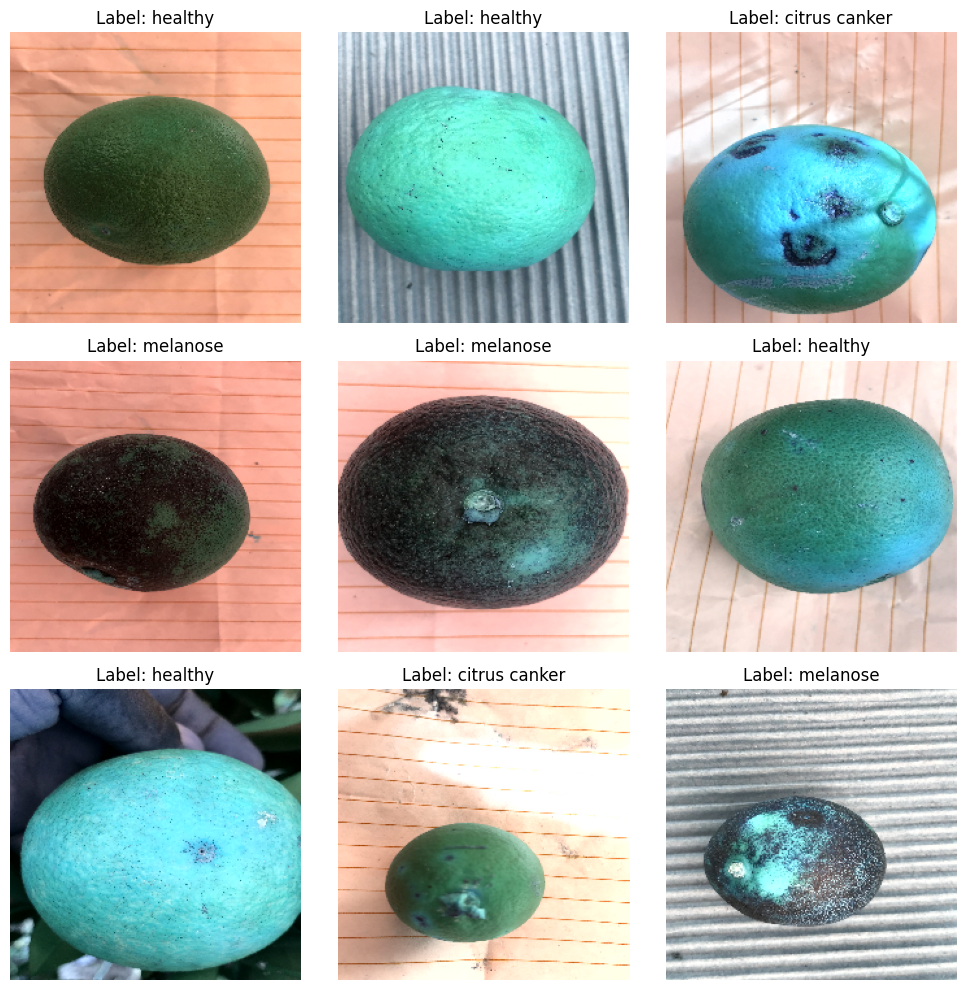

In [19]:
# Display Sample Images
def display_sample_images(X, y_encoded, label_encoder, num_samples=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(X), num_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[idx])
        plt.title(f"Label: {label_encoder.inverse_transform([y_encoded[idx]])[0]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_sample_images(X, y_encoded, label_encoder)

In [20]:
X = X.astype(np.uint8)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


print(f"Dataset Loaded: {X_train.shape[0]} training images, {X_test.shape[0]} test images")

Dataset Loaded: 6639 training images, 1660 test images


In [21]:
# Data Augmentation
data_gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [23]:
def extract_features(model, X_data):
    features = model.predict(X_data, verbose=1)
    return features.reshape(features.shape[0], -1)

In [24]:
# Extract features only once!
X_train_features = extract_features(base_model, X_train)
X_test_features = extract_features(base_model, X_test)

208/208 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step


Grad-CAM visualization script is ready. Use visualize_feature_extraction() with an image path.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step





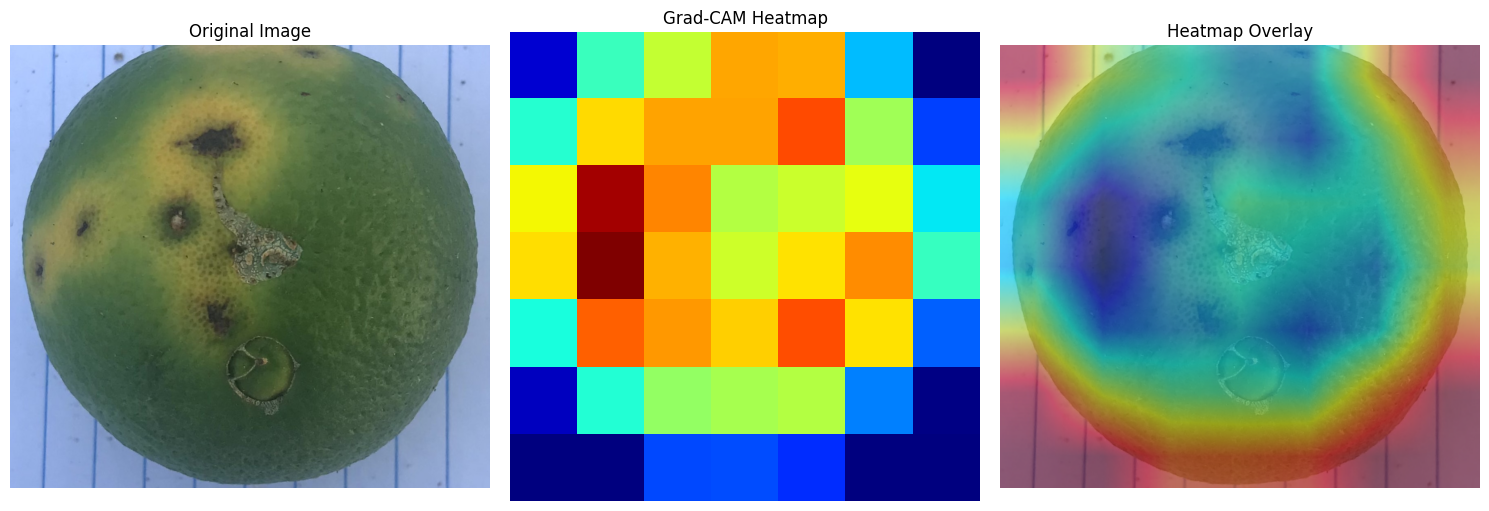

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

def create_gradcam_model(base_model):
    """
    Create a Grad-CAM compatible model for feature visualization.

    Args:
        base_model: Pretrained base model (EfficientNetB0)

    Returns:
        Tuple of (gradient model, last convolutional layer name)
    """
    # Identify the last convolutional layer for Grad-CAM
    last_conv_layer_name = 'top_conv'

    # Create a model that maps the input image to the last conv layer and output predictions
    grad_model = tf.keras.models.Model(
        base_model.input,  
        [base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    return grad_model, last_conv_layer_name

def get_gradcam_heatmap(img_array, grad_model, last_conv_layer_name, pred_index=None):
    """
    Generate a Grad-CAM heatmap.

    Args:
        img_array: Preprocessed input image array
        grad_model: Gradient model for feature extraction
        last_conv_layer_name: Name of the last convolutional layer
        pred_index: Index of the class to visualize (optional)

    Returns:
        Normalized heatmap
    """
    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(img_array)

        # If no specific class index is provided, use the top predicted class
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])

        # Compute loss for the specific class
        class_output = predictions[0, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Global Average Pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Convert to numpy for processing
    conv_outputs_np = conv_outputs.numpy()[0]
    pooled_grads_np = pooled_grads.numpy()

    # Multiply feature maps by pooled gradients
    for i in range(len(pooled_grads_np)):
        conv_outputs_np[:, :, i] *= pooled_grads_np[i]

    # Create heatmap
    heatmap = np.mean(conv_outputs_np, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.5):
    """
    Overlay the Grad-CAM heatmap onto the original image.

    Args:
        img: Original image
        heatmap: Computed Grad-CAM heatmap
        alpha: Transparency of the heatmap

    Returns:
        Image with heatmap overlay
    """
    # Resize heatmap to original image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to color
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    return superimposed_img

def visualize_feature_extraction(image_path, model=None, top_predictions=3):
    """
    Visualize feature extraction using Grad-CAM.

    Args:
        image_path: Path to the input image
        model: Optional pre-configured model (for reuse)
        top_predictions: Number of top predictions to display
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize and preprocess for EfficientNetB0
    input_img = cv2.resize(img, (224, 224))
    input_array = img_to_array(input_img)
    input_array = np.expand_dims(input_array, axis=0)
    input_array = preprocess_input(input_array)

    # Load pre-trained model if not provided
    if model is None:
        base_model = EfficientNetB0(weights='imagenet', include_top=True)
        grad_model, last_conv_layer_name = create_gradcam_model(base_model)
    else:
        grad_model, last_conv_layer_name = model

    # Predict class
    predictions = grad_model.predict(input_array)
    preds = predictions[1]  # Second output is the predictions
    class_names = decode_predictions(preds, top=top_predictions)[0]
    # print("Top predictions:")
    for (imagenet_id, label, score) in class_names:
        print()

    # Compute Grad-CAM heatmap for the top predicted class
    top_class_index = np.argmax(preds)
    heatmap = get_gradcam_heatmap(input_array, grad_model, last_conv_layer_name, pred_index=top_class_index)

    # Create overlay
    overlayed_img = overlay_heatmap(img, heatmap)

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_img)
    plt.title("Heatmap Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Demonstrative example for how to use the function
def main():
    # Configure the model once to improve performance
    base_model = EfficientNetB0(weights='imagenet', include_top=True)
    grad_model, last_conv_layer_name = create_gradcam_model(base_model)

    print("Grad-CAM visualization script is ready. Use visualize_feature_extraction() with an image path.")

if __name__ == "__main__":
    main()

# Run Grad-CAM on a test image
visualize_feature_extraction("test/citrus canker/c (2608).jpg")


In [30]:
!pip install opencv-python numpy tensorflow scikit-image scikit-learn tqdm

     ---------------------------------------- 12.8/12.8 MB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 1.1 MB/s eta 0:00:00
     -------------------------------------- 226.8/226.8 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 680.9 kB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\shash\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\~il\\_imaging.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

!pip install cupy-cuda112

     ---------------------------------      53.7/60.2 MB 653.1 kB/s eta 0:00:10


ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    cupy-cuda112 from https://files.pythonhosted.org/packages/b3/61/d3ba441f1fc4f300996ab6c1784aacfbfe3a6ad093ab6d00bea03ec90aec/cupy_cuda112-10.6.0-cp310-cp310-win_amd64.whl:
        Expected sha256 5d5adc75ea17b3ae09734f4bb4668501c66df4d4379f60aa32f1eff48a2021b3
             Got        922fadad4096240a1e5bda7bf8d81e27b5828aa1487dca7898cd87ab5d44acce


[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

def extract_features(image_path, model):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image).astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)

    features = model.predict(image)
    return features.flatten()


def load_dataset(image_folder, model):
    X, y = [], []
    class_labels = os.listdir(image_folder)

    for label in tqdm(class_labels, desc="Processing Classes"):
        class_path = os.path.join(image_folder, label)
        if not os.path.isdir(class_path):
            continue

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            try:
                features = extract_features(image_path, model)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Skipping {image_path}: {e}")

    X = np.array(X)  # Shape: (n_samples, n_features)
    y = np.array(y)  # Shape: (n_samples,)
    return X, y, class_labels


def train_and_evaluate(X, y):
    # Convert string labels to integers
    le = LabelEncoder()
    y = le.fit_transform(y)  # Now y contains integers (e.g., 0, 1, 2)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Random Forest 
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

    # Support Vector Machine 
    svm = SVC(kernel="linear", probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


if __name__ == "__main__":
    image_folder = "train"  # Update to your dataset path
    base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

    X, y, class_labels = load_dataset(image_folder, base_model)

    train_and_evaluate(X, y)


Processing Classes:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━

Processing Classes:  33%|███▎      | 1/3 [17:18<34:36, 1038.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

Processing Classes:  67%|██████▋   | 2/3 [34:16<17:06, 1026.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/s

Processing Classes: 100%|██████████| 3/3 [58:06<00:00, 1162.21s/it]


Random Forest Accuracy: 0.8446
SVM Accuracy: 0.8892


In [42]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)
rf_preds = rf.predict(X_test_features)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Accuracy: 0.8210843373493976


In [43]:
import pickle

# Save the model
with open("random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)


In [45]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [46]:
# Initialize models
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest rf": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [47]:

# Train models & evaluate accuracy
results = {}
for name, model in models.items():
    model.fit(X_train_features, y_train)
    y_pred = model.predict(X_test_features)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Naive Bayes Accuracy: 0.5211
Random Forest rf Accuracy: 0.8211
MLP Accuracy: 0.3494
Decision Tree Accuracy: 0.6663


In [49]:
import joblib
import os

# Define save path
save_dir = "Models"

# Save each trained model
for name, model in models.items():
    filename = os.path.join(save_dir, f"{name.lower().replace(' ', '_')}.pkl")  # Format: random_forest.pkl, naive_bayes.pkl, etc.
    joblib.dump(model, filename)
    print(f"Saved: {filename}")


Saved: Models\naive_bayes.pkl
Saved: Models\random_forest_rf.pkl
Saved: Models\mlp.pkl
Saved: Models\decision_tree.pkl


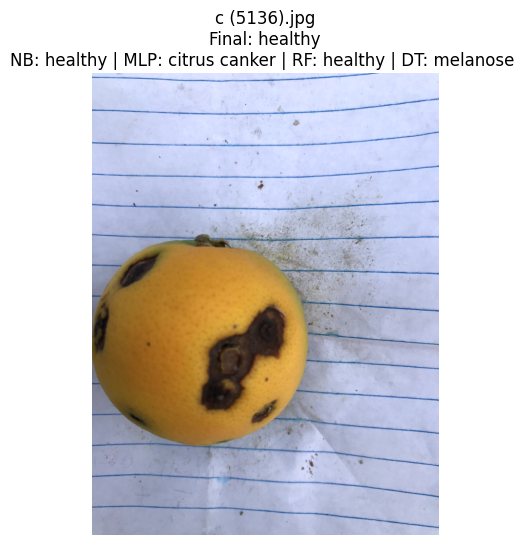

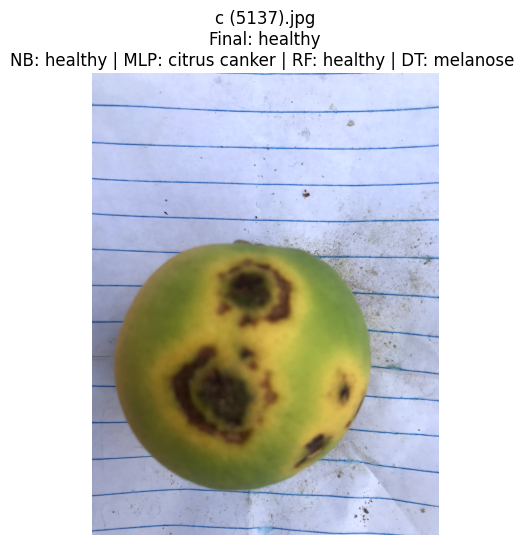

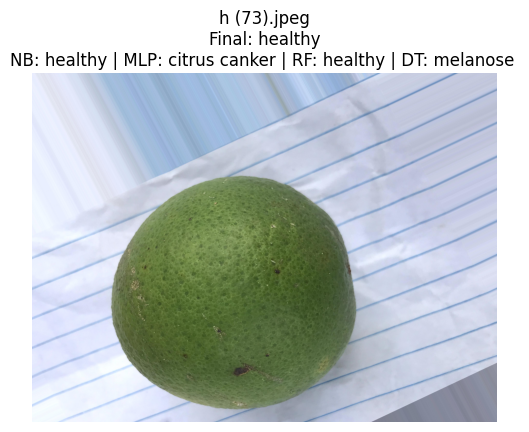

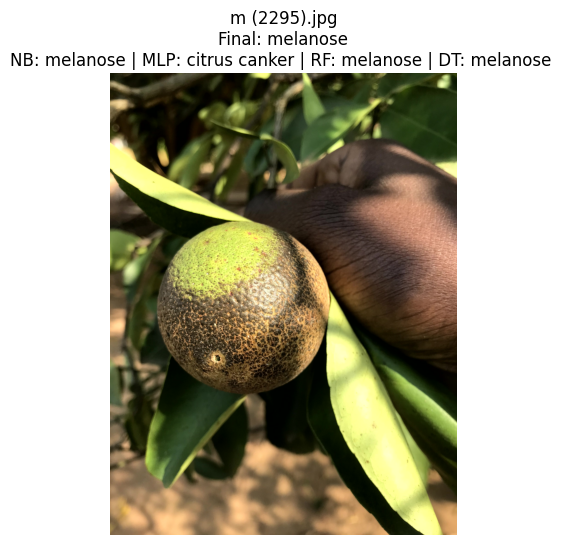

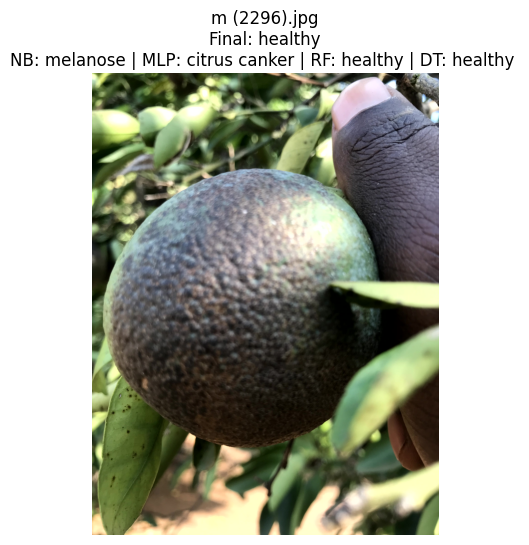

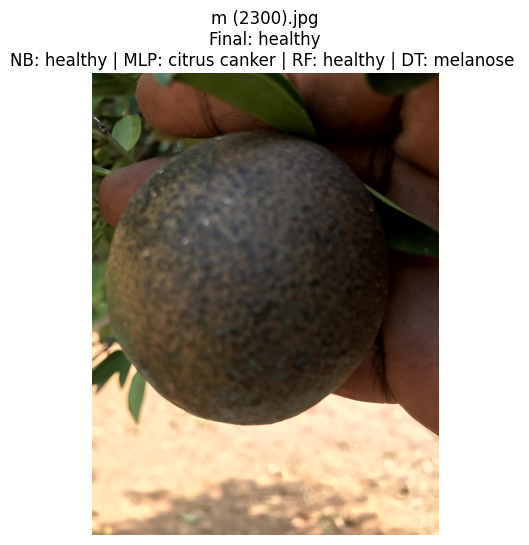

In [14]:
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from collections import Counter

# Load Pretrained Model for Feature Extraction
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

def extract_features(model, X_data):
    features = model.predict(X_data, verbose=0)
    return features.reshape(features.shape[0], -1)  # Flatten extracted features

# Load Trained Models
nb = joblib.load("Models/naive_bayes.pkl")
mlp = joblib.load("Models/mlp.pkl")
rf = joblib.load("Models/random_forest.pkl")
dt = joblib.load("Models/decision_tree.pkl")

# Function to Get Majority Vote
def majority_voting(predictions):
    counter = Counter(predictions)
    most_common = counter.most_common()

    # Check if there's a tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return most_common[np.random.randint(0, len(most_common))][0]  # Randomly choose among ties
    return most_common[0][0]  # Most frequent prediction

def test_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, filename)

            # Read and preprocess image
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img_resized = cv2.resize(img, (224, 224)).astype("float32") / 255.0
            img_array = np.expand_dims(img_resized, axis=0)

            # Extract features for ML models
            img_features = extract_features(base_model, img_array)
            img_features = img_features.reshape(1, -1)  # Flatten for ML models

            # Predictions
            predictions = [
                label_encoder.inverse_transform([nb.predict(img_features)[0]])[0],
                label_encoder.inverse_transform([mlp.predict(img_features)[0]])[0],
                label_encoder.inverse_transform([rf.predict(img_features)[0]])[0],
                label_encoder.inverse_transform([dt.predict(img_features)[0]])[0]
            ]

            # Majority Voting Result
            final_prediction = majority_voting(predictions)

            # Display Results
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"{filename}\nFinal: {final_prediction}\nNB: {predictions[0]} | MLP: {predictions[1]} | RF: {predictions[2]} | DT: {predictions[3]} ")
            plt.axis("off")
            plt.show()

# Example usage
test_images_in_folder("Random_Tester")
